In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  %load_ext autoreload
  %autoreload 2
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.spectrogram_model import spectrogram_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

Wrong working directory
/Users/carlos/Documents/LeTaffe/PROJET_ESSAI
New directory : /Users/carlos/Documents/LeTaffe/PROJET_ESSAI


In [3]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

Using cpu


## Downloading and setting up the dataset

In [4]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    train_set = SubsetSC("training",root)
    test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

training & test sets finished in  0:01:21.247127


## Let's visualize the data !

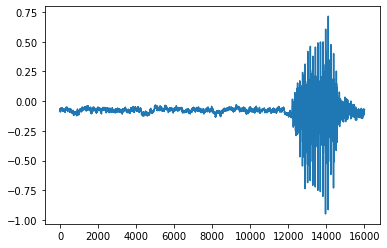

In [5]:
plt.plot(storage['waveform'].t().numpy())

In [6]:
n_fft=400
n_mels=50

### Spectrogram transform

Shape of spectrogram: torch.Size([1, 201, 81])


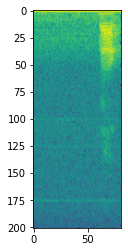

In [7]:
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft)
spectrogram=spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure()
plt.imshow(spectrogram.log2()[0].numpy())

### Mel's spectrogram

Shape of spectrogram: torch.Size([1, 50, 81])


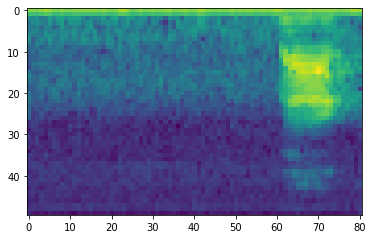

In [8]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,n_mels=n_mels)
spectrogram_spec=mel_spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram_spec.size()))

plt.figure()
p = plt.imshow(spectrogram_spec.log2()[0].detach().numpy())

### MFCC

Shape of spectrogram: torch.Size([1, 40, 32])


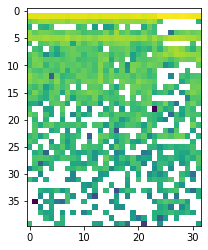

In [9]:
MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": 512,
        "mel_scale": "htk",
    })
MFCC_spec=MFCC_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(MFCC_spec.size()))

plt.figure()
p = plt.imshow(MFCC_spec.log2()[0].detach().numpy())

### MuLaw encoding

Shape of transformed waveform: torch.Size([1, 16000])


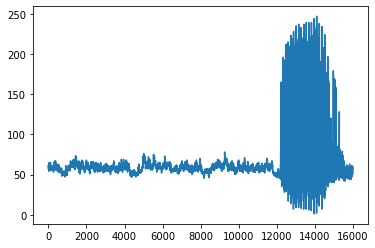

In [10]:
MuLaw_transform=torchaudio.transforms.MuLawEncoding()
muLawEncoding=MuLaw_transform(storage['waveform'])
print("Shape of transformed waveform: {}".format(muLawEncoding.size()))

plt.figure()
plt.plot(muLawEncoding[0,:].numpy())

Shape of recovered waveform: torch.Size([1, 16000])


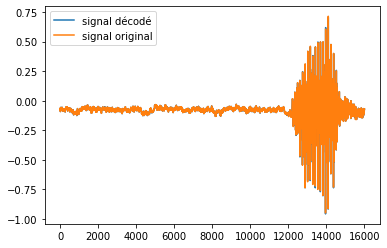

In [11]:
reconstructed = torchaudio.transforms.MuLawDecoding()(muLawEncoding)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy(),label='signal décodé')
plt.plot(storage['waveform'].t().numpy(),label='signal original')
plt.legend()

## Resampling the data and setting the transform

In [12]:
new_sample_rate=8000
layers =[]
layers.append(torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate))
layers.append(spectrogram_transform)
storage['transform'] = nn.Sequential(*layers)
waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

torch.Size([1, 201, 41])


## Setting up the test and train loader

In [13]:
batch_size = 256

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [14]:
storage['model'] = spectrogram_model(input_shape=waveform_size, n_output=len(train_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

Number of parameters: 147011


## Define the optimizer, loss function & metrics

In [15]:
# Define the Optimizer
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=0.01, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.nll_loss
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [16]:
storage['log_interval'] = 20
storage['n_epoch'] = 2

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

## Train and testing

In [ ]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            train(storage)
            test(storage)
            storage['scheduler'].step()

  0%|          | 0/2 [00:00<?, ?it/s]/Users/carlos/Documents/LeTaffe/PROJET_ESSAI/models/spectrogram_model.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
  0%|          | 0.0026666666666666666/2 [00:01<13:37, 409.44s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 5.117665


  3%|▎         | 0.05599999999999999/2 [00:19<10:53, 336.10s/it]  

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.556099


  5%|▌         | 0.10933333333333328/2 [00:36<10:32, 334.40s/it] 

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.494363


  8%|▊         | 0.16266666666666676/2 [00:56<11:17, 368.61s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.483211


 11%|█         | 0.21600000000000033/2 [01:15<10:53, 366.29s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 3.422865


 13%|█▎        | 0.2693333333333337/2 [01:34<09:45, 338.12s/it] 

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.328748


 16%|█▌        | 0.3226666666666667/2 [01:51<09:19, 333.43s/it] 

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.212852


 19%|█▉        | 0.3759999999999997/2 [02:09<08:59, 332.01s/it] 

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.141424


 21%|██▏       | 0.42933333333333273/2 [02:27<08:51, 338.14s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 2.975986


 24%|██▍       | 0.48266666666666574/2 [02:45<08:29, 335.57s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.246023


 27%|██▋       | 0.5359999999999995/2 [03:03<08:11, 335.39s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 2.970183


 29%|██▉       | 0.5893333333333336/2 [03:21<08:01, 341.51s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 2.871350


 32%|███▏      | 0.6426666666666677/2 [03:39<07:40, 339.16s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 2.944803


 35%|███▍      | 0.6960000000000018/2 [03:57<07:17, 335.29s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 3.034472


 37%|███▋      | 0.749333333333336/2 [04:15<06:58, 334.29s/it] 

Train Epoch: 2 [71680/84843 (84%)]	Loss: 2.912935


 40%|████      | 0.8026666666666701/2 [04:32<06:42, 336.07s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 2.920876


 43%|████▎     | 0.8560000000000042/2 [04:50<06:30, 341.29s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 2.997752


 50%|█████     | 1.0000000000000062/2 [05:20<03:04, 184.39s/it]


Test Epoch: 2	Accuracy: 2428/11005 (22%)



 50%|█████     | 1.0026666666666728/2 [05:21<03:55, 236.47s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 2.902172


 53%|█████▎    | 1.0560000000000047/2 [05:39<05:11, 329.90s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 2.947330


 55%|█████▌    | 1.1093333333333366/2 [05:57<04:54, 330.77s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 2.847269


 58%|█████▊    | 1.1626666666666685/2 [06:14<04:36, 330.80s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 2.902275


 61%|██████    | 1.2160000000000004/2 [06:32<04:22, 335.18s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 2.975465


 63%|██████▎   | 1.2693333333333323/2 [06:50<04:02, 332.27s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 2.935077


 66%|██████▌   | 1.3226666666666642/2 [07:09<04:05, 362.07s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 2.912449


 69%|██████▉   | 1.3759999999999961/2 [07:27<03:36, 347.21s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 2.957247


 71%|███████▏  | 1.429333333333328/2 [07:46<03:26, 362.47s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 2.776603


 74%|███████▍  | 1.48266666666666/2 [08:07<03:18, 384.13s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 2.824654


 77%|███████▋  | 1.5359999999999918/2 [08:28<02:57, 382.65s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 2.846087


 79%|███████▉  | 1.5893333333333237/2 [08:48<02:35, 379.49s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 2.919931


 82%|████████▏ | 1.6426666666666556/2 [09:08<02:03, 346.82s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 2.793489


 85%|████████▍ | 1.6959999999999875/2 [09:28<01:50, 363.58s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 2.807190


 87%|████████▋ | 1.7493333333333194/2 [09:47<01:31, 366.88s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 2.929082


 90%|█████████ | 1.8026666666666513/2 [10:07<01:16, 388.85s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 2.734990


 91%|█████████ | 1.823999999999984/2 [10:16<01:08, 391.52s/it] 

In [ ]:
plt.plot(storage['losses']);
plt.title("training loss");

In [ ]:
showResult(storage['model'])